# [FE800] Group 4: Phase 1:3 - Total and Residual Momentum Spillover

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil import relativedelta
import calendar
import matplotlib.pyplot as plt
from matplotlib import style
import math

# Functions

## Ranking Equity Return function

In [2]:
def rank_port_decile(equity_data , formation_date, num_month, strat_type = 0):
    
    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    avg_date =  form_date - relativedelta.relativedelta(months = num_month)
    check_last_day = calendar.monthrange(avg_date.year, avg_date.month)
    avg_date = datetime(avg_date.year, avg_date.month, check_last_day[-1])
    
    equity_data_ = equity_data[(equity_data.date >= avg_date) & (equity_data.date <= form_date)]
    equity_data_ = equity_data_.drop_duplicates()
    try:
        equity_data_ = equity_data_[equity_data_.RETX != 'C']
    except:
        print('There is no C')
    equity_data_.RETX = equity_data_.RETX.astype('float64')
    equity_data_.RET = equity_data_.RET.astype('float64')
    
    #residual
    if strat_type != 0:
        equity_data_.RETX = equity_data_.RETX - equity_data_.RF
    
    equity_data_.RETX = equity_data_.RETX.add(1) #cumulative
    
    #equity_group_mean_ret = equity_data_.groupby('TICKER').agg({'RETX': 'mean'})
    equity_group_mean_ret = equity_data_.groupby('TICKER').agg({'RETX': 'prod'}) #cumulative
    equity_group_mean_ret = equity_group_mean_ret.subtract(1) #cumulative
    equity_group_mean_ret_sort = equity_group_mean_ret.sort_values(by=['RETX'])
    equity_group_mean_ret_sort['GROUP'] = 0
    
    frac = math.floor(equity_group_mean_ret_sort.shape[0]/10)

    num_line = equity_group_mean_ret_sort.shape[0]
    left = num_line%frac

    group_num = [frac+1]*(left)+[frac]*(10-left)
    group = ['P10', 'P09', 'P08', 'P07', 'P06', 'P05', 'P04', 'P03', 'P02', 'P01']
    
    i, j = 0, group_num[0]
    while j <= num_line:
        
        equity_group_mean_ret_sort.ix[(j-group_num[i]):j , 'GROUP'] = group[i]
        i +=1
        if(i == 10):
            break
        j = j + group_num[i]

    return(equity_group_mean_ret_sort)

## Generating Ranking Summary table function

In [3]:
def rank_table(rank_port, universe, strat_type = 0):
    
    rank_port_sort = rank_port
    rank_port_sort['TICKER'] = rank_port_sort.index
    rank_port_sort = rank_port.sort_values(by=['GROUP', 'TICKER'])
    rank_port_sort_sum = rank_port_sort.groupby('GROUP').agg({'TICKER':'count', 'RETX':'mean'})
    rank_port_sort_sum.loc['Total'] = rank_port_sort_sum.sum()
    
    strat_name = np.where(strat_type == 0, 'Total', 'Residual')
    
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(8)
    plt.subplots_adjust(left=0.5, top=0.8)
    ax.set_title('Ranking {0} Equity Returns \n From Winner to Loser Portfolios - {1}'.format(strat_name, universe), fontsize=15, weight='bold')
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    
    data = rank_port_sort_sum.round(6).values
    columns = ['Company numbers', 'Average returns']
    rows = rank_port_sort_sum.index
    
    rcolors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
    ccolors = rcolors[::-1]
    clcolors = []
    for i in range(0, 10):
        clcolors.append(["w","w"])
    #clcolors.append(["#92a4cd","#92a4cd"])
    clcolors.append(["#8c95c6","#8c95c6"])
    
    plt.table(cellText = data, cellColours=clcolors,
                          rowLabels=rows,
                          colLabels=columns,rowColours=rcolors, colColours=ccolors, loc='center')
    fig.tight_layout()
    

## Running Total Momentum Spillover Strategy function

In [4]:
def momentum_strategy(bond_data, rank_port, start_month, end_month, TMT = 2):

    bond_data = pd.merge(bond_data, rank_port[['GROUP']], how = 'left', left_on = 'company_symbol', right_index=True)
    bond_data = bond_data[bond_data.TMT >= TMT]
    bond_data = bond_data.dropna(subset=['RET_EOM', 'DURATION'])
    
    bond_average_month = bond_data.groupby(['month', 'company_symbol', 'GROUP']).agg({'PRICE_EOM':'mean','RET_EOM':'mean', 'RATING_NUM':'mean', 'DURATION':'mean'})

    bond_month = pd.DataFrame(columns = ['month', 'ticker', 'port_group', 'price', 'return', 'avg_rating', 'duration'])
    bond_month['month'] = [i[0] for i in bond_average_month.index]
    bond_month['ticker'] = [i[1] for i in bond_average_month.index]
    bond_month['port_group'] = [i[2] for i in bond_average_month.index]
    bond_month['price'] = bond_average_month['PRICE_EOM'].values
    bond_month['return'] = bond_average_month['RET_EOM'].values
    bond_month['avg_rating'] = bond_average_month['RATING_NUM'].values
    bond_month['duration'] = bond_average_month['DURATION'].values
    bond_hold = bond_month[(bond_month.month >= start_month) & (bond_month.month <= end_month)]
    
    
    bond_sum_price = bond_hold.groupby(['port_group', 'month']).agg({'price':'sum'})
    bond_sum_price['port_group'] = [i[0] for i in bond_sum_price.index]
    bond_sum_price['month'] = [i[1] for i in bond_sum_price.index]
    
    bond_hold_value = pd.merge(bond_hold, bond_sum_price, how = 'left', left_on = ['port_group', 'month'], right_on=['port_group', 'month'])
    bond_hold_value.columns = ['month', 'ticker', 'port_group', 'price', 'return', 'avg_rating', 'duration','port_total_weight']
    bond_hold_value['port_weight'] = bond_hold_value['price'].divide(bond_hold_value['port_total_weight'])
    bond_hold_value['value_return'] = bond_hold_value['return'].mul(bond_hold_value['port_weight'])
    bond_hold_value['value_price'] = bond_hold_value['price'].mul(bond_hold_value['port_weight'])
    bond_hold_value['value_rating'] = bond_hold_value['avg_rating'].mul(bond_hold_value['port_weight'])
    bond_hold_value['value_duration'] = bond_hold_value['duration'].mul(bond_hold_value['port_weight'])
    
    # Value portfolio
    bond_hold_value_ = bond_hold_value.groupby(['port_group', 'month', 'ticker']).agg({'value_return':'sum', 'value_price':'sum', 'value_duration':'sum', 'value_rating':'sum'})
    bond_hold_value_['port_group'] = [i[0] for i in bond_hold_value_.index]
    bond_hold_value_['month'] = [i[1] for i in bond_hold_value_.index]
    bond_hold_value_['ticker'] = [i[2] for i in bond_hold_value_.index]
    bond_hold_value_['value_return'] = bond_hold_value_['value_return'].add(1)
    
    bond_hold_value__ = bond_hold_value_.groupby(['port_group', 'ticker']).agg({'value_return':'prod', 'value_price':lambda x: x.iloc[-1],'value_duration':lambda x: x.iloc[-1], 'value_rating':lambda x: x.iloc[-1]})
    bond_hold_value__['port_group'] = [i[0] for i in bond_hold_value__.index]
    bond_hold_value__['ticker'] = [i[1] for i in bond_hold_value__.index]
    bond_hold_value__['value_return'] = bond_hold_value__['value_return'].subtract(1)
    
    bond_hold_valueW = bond_hold_value__.groupby(['port_group']).agg({'value_return':'sum', 'value_price':'sum','value_duration':'sum', 'value_rating':'sum'})
    bond_hold_valueW.loc['P01-P10'] = bond_hold_valueW.ix[0,0] - bond_hold_valueW.ix[-1,0]
    bond_hold_valueW.loc['P01-P05'] = bond_hold_valueW.ix[0,0] - bond_hold_valueW.ix[4,0]
    
    #Equal portfolio
    bond_hold_value___ = bond_hold_value
    bond_hold_value___['return'] = bond_hold_value___['return'].add(1)
    bond_hold_equalW_ = bond_hold_value___.groupby(['port_group', 'ticker']).agg({'return':'prod', 'price':lambda x: x.iloc[-1], 'avg_rating':lambda x: x.iloc[-1], 'duration': lambda x: x.iloc[-1]})
    bond_hold_equalW_['port_group'] = [i[0] for i in bond_hold_equalW_.index]
    bond_hold_equalW_['ticker'] = [i[1] for i in bond_hold_equalW_.index]
    bond_hold_equalW_['return'] = bond_hold_equalW_['return'].subtract(1)
    bond_hold_equalW = bond_hold_equalW_.groupby('port_group').agg({'return':'mean', 'price':'mean', 'avg_rating':'mean', 'duration': 'mean', 'ticker': lambda x: x.nunique()})
    bond_hold_equalW.loc['P01-P10'] = bond_hold_equalW.ix[0,0] - bond_hold_equalW.ix[-1,0]
    bond_hold_equalW.loc['P01-P05'] = bond_hold_equalW.ix[0,0] - bond_hold_equalW.ix[4,0]
    
    result_ = bond_hold_valueW.merge(bond_hold_equalW, left_index=True, right_index=True)
    text1 = 'value_wight'+'('+str(start_month)+','+str(end_month)+')'
    text2 = 'equal_weight'+'('+str(start_month)+','+str(end_month)+')'
    result__ = pd.DataFrame(columns = [text1, text2, 'value_price', 'equal_price', 'value_rating', 'equal_rating', 'value_duration', 'equal_duration', 'com_num'])
    result__[text1] = result_.iloc[:, 0]
    result__[text2] = result_.iloc[:, 4]
    result__['value_price'] = result_.iloc[:, 1]
    result__['equal_price'] = result_.iloc[:, 5]
    result__['value_rating'] = result_.iloc[:, 3]
    result__['equal_rating'] = result_.iloc[:, 6]
    result__['value_duration'] = result_.iloc[:, 2]
    result__['equal_duration'] = result_.iloc[:, 7]
    result__['com_num'] = result_.iloc[:, 8]
    result__.ix[10:,2:] = 0
    
    result = pd.DataFrame(data = 0, columns = result__.columns, index = ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10'])
    
    for i in result__.index:
        result.loc[i] = result__.loc[i]
    
    return(result)

## Generating Total Momentum Spillover Stategy Summary table function

In [5]:
def m_performance_table(perf, universe, strat_type = 0):
    strat_name = np.where(strat_type == 0, 'Total', 'Residual')
    
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(14)
    plt.subplots_adjust(left=0.5, top=0.8)
    ax.set_title('{0} Momentum Spillover Performance Table - {1}'.format(strat_name, universe), fontsize=15, weight='bold')
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    
    data = perf.round(4).values
    columns = perf.columns
    rows = perf.index
    
    rcolors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
    ccolors = rcolors[::-1]
    clcolors = []
    for i in range(0, 10):
        clcolors.append(["w","w","w","w","w","w","w","w","w"])
    clcolors.append(["#92a4cd","#92a4cd","#92a4cd","#92a4cd","#92a4cd","#92a4cd", "#92a4cd", "#92a4cd", "#92a4cd"])
    clcolors.append(["#8c95c6","#8c95c6","#8c95c6","#8c95c6","#8c95c6","#8c95c6", "#8c95c6", "#8c95c6", "#8c95c6"])
    
    plt.table(cellText = data, cellColours=clcolors,
                          rowLabels=rows,
                          colLabels=columns,rowColours=rcolors, colColours=ccolors, loc='center')
    fig.tight_layout()

## Momentum Spillover Strategy Performance Visualization function

In [6]:
def performance_plot(perf, avg_period, start, end, tmt, universe, strat_type = 0):

    style.use('seaborn')
    
    fig = plt.figure(figsize=(18, 15))
    strat_name = np.where(strat_type == 0, 'Total', 'Residual')
    fig.suptitle('{0} Momentum Spillover Performance - {1}'.format(strat_name, universe), fontsize=20, fontweight='bold')
    
    plt.figtext(0.5,0.95, "Average {0}-month equity returns \n Holding bond portfolios from {1} to {2} \n Time-to-maturity over {3}".format(avg_period, start, end, tmt), ha="center", va="top", fontsize=14, color="black")
    
    ax1 = plt.subplot2grid((30, 22), (0, 0), rowspan=10, colspan=13)
    ax1.plot(perf.iloc[0:10, 0], label="{0}".format(perf.columns[0]), color='SteelBlue')
    ax1.annotate("{0:0.5f}".format(perf.iloc[0,0]), xy=(0, perf.iloc[0,0]), xytext=(8, 6), xycoords=('axes fraction', 'data'), textcoords='offset points')
    ax1.annotate("{0:0.5f}".format(perf.iloc[-3,0]), xy=(1, perf.iloc[-3,0]), xytext=(8, 6), xycoords=('axes fraction', 'data'), textcoords='offset points')
    
    ax1.plot(perf.iloc[0:10, 1], label="{0}".format(perf.columns[1]), color='IndianRed')
    ax1.annotate("{0:0.5f}".format(perf.iloc[0,1]), xy=(0, perf.iloc[0,1]), xytext=(8, 6), xycoords=('axes fraction', 'data'), textcoords='offset points')
    ax1.annotate("{0:0.5f}".format(perf.iloc[-3,1]), xy=(1, perf.iloc[-3,1]), xytext=(8, 6), xycoords=('axes fraction', 'data'), textcoords='offset points')
    ax1.set_title('{0} momemtum Spillover Curves from Winner to Loser Portfolios'.format(strat_name), fontsize=15, weight='bold')
    ax1.set_ylabel('Cumulative return')
    ax1.legend()
    
    ax2 = plt.subplot2grid((30, 22), (0, 15), rowspan=10, colspan=6)
    
    index = np.arange(2)
    bar_width = 0.35
    opacity = 0.8
    
    rect1 = ax2.bar(index - bar_width/2, perf.iloc[10:12,0].values, bar_width, color='SkyBlue', label="{0}".format(perf.columns[0]))
    for rect in rect1:
        height1 = rect.get_height()
        ax2.text(rect.get_x() + rect.get_width()/2., 1.01*height1,
                    "{0:0.5f}".format(height1),
                    ha='center', va='bottom')
    
    rect2 = ax2.bar(index + bar_width/2, perf.iloc[10:12,1].values, bar_width, color='IndianRed', alpha=opacity, label="{0}".format(perf.columns[1]))
    for rect in rect2:
        height2 = rect.get_height()
        ax2.text(rect.get_x() + rect.get_width()/2., 1.01*height2,
                    "{0:0.5f}".format(height2),
                    ha='center', va='bottom')
    
    ax2.set_xticks(index)
    ax2.set_xticklabels((perf.index[-2], perf.index[-1]))
    ax2.set_ylabel('Long-short Cumulative return')
    ax2.set_title('Long-short Performance', fontsize=15, weight='bold')
    ax2.legend()
    
    ax3 = plt.subplot2grid((30, 22), (12, 0), rowspan=6, colspan=10)
    ax3.plot(perf.iloc[0:10, 2], 'o-',label="Value price", color='orchid')
    ax3.plot(perf.iloc[0:10, 3], 'o-',label="Equal price", color='turquoise')
    ax3.set_title('Bond Prices from Winner to Loser Portfolios', fontsize=15, weight='bold')
    for i in range(0,10):
        ax3.text(i,1.001*perf.iloc[i, 2], '{0:.2f}'.format(perf.iloc[i, 2]), ha='center', va='bottom')
        ax3.text(i,1.001*perf.iloc[i, 3], '{0:.2f}'.format(perf.iloc[i, 3]), ha='center', va='bottom')
    ax3.legend()
    
    ax4 = plt.subplot2grid((30, 22), (12, 11), rowspan=6, colspan=10)
    ax4.plot(perf.iloc[0:10, 4], 'o-', label="Value credit rating", color='orchid')
    ax4.plot(perf.iloc[0:10, 5], 'o-', label="Equal credit rating", color='turquoise')
    ax4.set_title('Credit Rating from Winner to Loser Portfolios', fontsize=15, weight='bold')
    for i in range(0,10):
        ax4.text(i,1.001*perf.iloc[i, 4], '{0:.2f}'.format(perf.iloc[i, 4]), ha='center', va='bottom')
        ax4.text(i,1.001*perf.iloc[i, 5], '{0:.2f}'.format(perf.iloc[i, 5]), ha='center', va='bottom')
    ax4.legend()
    
    ax5 = plt.subplot2grid((30, 22), (20, 0), rowspan=6, colspan=10)
    ax5.plot(perf.iloc[0:10, 6], 'o-', label="Value durations", color='orchid')
    ax5.plot(perf.iloc[0:10, 7], 'o-', label="Equal durations", color='turquoise')
    ax5.set_title('Durations from Winner to Loser Portfolios', fontsize=15, weight='bold')
    for i in range(0,10):
        ax5.text(i,1.001*perf.iloc[i, 6], '{0:.2f}'.format(perf.iloc[i, 6]), ha='center', va='bottom')
        ax5.text(i,1.001*perf.iloc[i, 7], '{0:.2f}'.format(perf.iloc[i, 7]), ha='center', va='bottom')
    ax5.legend()
    
    ax6 = plt.subplot2grid((30, 22), (20, 11), rowspan=6, colspan=10)
    rect3 = ax6.bar(perf.index[0:10].values, perf.iloc[0:10, 8], bar_width, color='deepskyblue', label="Number of companies")
    for rect in rect3:
        height3 = rect.get_height()
        ax6.text(rect.get_x() + rect.get_width()/2., 1.01*height3,
                    "{0}".format(int(height3)),
                    ha='center', va='bottom')
    
    ax6.set_title('Total Company Numbers from Winner to Loser Portfolios', fontsize=15, weight='bold')


## Performance comparison function

In [7]:
def comparison_performance(equity_data, bond_data, holding_range, formation_date, equity_range, TMT=2, strat_type = 0):
    rank1_port = rank_port_decile(equity_data, formation_date, equity_range[0], strat_type=strat_type)
    rank2_port = rank_port_decile(equity_data, formation_date, equity_range[1], strat_type=strat_type)
    rank3_port = rank_port_decile(equity_data, formation_date, equity_range[2], strat_type=strat_type)
    
    avg_period = (equity_range[0], equity_range[1], equity_range[2])
    
    perf1_1 = momentum_strategy(bond_data, rank1_port, holding_range[0][0], holding_range[0][1], TMT=TMT)
    perf1_1_ = perf1_1.iloc[:, 0:2].add(1).pow(12/(holding_range[0][1] - holding_range[0][0] + 1)).subtract(1)
    perf1_2 = momentum_strategy(bond_data, rank1_port, holding_range[1][0], holding_range[1][1], TMT=TMT)
    perf1_2_ = perf1_2.iloc[:, 0:2].add(1).pow(12/(holding_range[1][1] - holding_range[1][0] + 1)).subtract(1)
    perf1_3 = momentum_strategy(bond_data, rank1_port, holding_range[2][0], holding_range[2][1], TMT=TMT)
    perf1_3_ = perf1_3.iloc[:, 0:2].add(1).pow(12/(holding_range[2][1] - holding_range[2][0] + 1)).subtract(1)
    perf1_4 = momentum_strategy(bond_data, rank1_port, holding_range[3][0], holding_range[3][1], TMT=TMT)
    perf1_4_ = perf1_4.iloc[:, 0:2].add(1).pow(12/(holding_range[3][1] - holding_range[3][0] + 1)).subtract(1)
    perf11 = [perf1_1_.iloc[-2, 0], perf1_1_.iloc[-2, 1], perf1_2_.iloc[-2, 0], perf1_2_.iloc[-2, 1], perf1_3_.iloc[-2, 0], perf1_3_.iloc[-2, 1], perf1_4_.iloc[-2, 0], perf1_4_.iloc[-2, 1]]
    perf12 = [perf1_1_.iloc[-1, 0], perf1_1_.iloc[-1, 1], perf1_2_.iloc[-1, 0], perf1_2_.iloc[-1, 1], perf1_3_.iloc[-1, 0], perf1_3_.iloc[-1, 1], perf1_4_.iloc[-1, 0], perf1_4_.iloc[-1, 1]]
    
    perf2_1 = momentum_strategy(bond_data, rank2_port, holding_range[0][0], holding_range[0][1], TMT=TMT)
    perf2_1_ = perf2_1.iloc[:, 0:2].add(1).pow(12/(holding_range[0][1] - holding_range[0][0] + 1)).subtract(1)
    perf2_2 = momentum_strategy(bond_data, rank2_port, holding_range[1][0], holding_range[1][1], TMT=TMT)
    perf2_2_ = perf2_2.iloc[:, 0:2].add(1).pow(12/(holding_range[1][1] - holding_range[1][0] + 1)).subtract(1)
    perf2_3 = momentum_strategy(bond_data, rank2_port, holding_range[2][0], holding_range[2][1], TMT=TMT)
    perf2_3_ = perf2_3.iloc[:, 0:2].add(1).pow(12/(holding_range[2][1] - holding_range[2][0] + 1)).subtract(1)
    perf2_4 = momentum_strategy(bond_data, rank2_port, holding_range[3][0], holding_range[3][1], TMT=TMT)
    perf2_4_ = perf2_4.iloc[:, 0:2].add(1).pow(12/(holding_range[3][1] - holding_range[3][0] + 1)).subtract(1)
    perf21 = [perf2_1_.iloc[-2, 0], perf2_1_.iloc[-2, 1], perf2_2_.iloc[-2, 0], perf2_2_.iloc[-2, 1], perf2_3_.iloc[-2, 0], perf2_3_.iloc[-2, 1], perf2_4_.iloc[-2, 0], perf2_4_.iloc[-2, 1]]
    perf22 = [perf2_1_.iloc[-1, 0], perf2_1_.iloc[-1, 1], perf2_2_.iloc[-1, 0], perf2_2_.iloc[-1, 1], perf2_3_.iloc[-1, 0], perf2_3_.iloc[-1, 1], perf2_4_.iloc[-1, 0], perf2_4_.iloc[-1, 1]]
    
    perf3_1 = momentum_strategy(bond_data, rank3_port, holding_range[0][0], holding_range[0][1], TMT=TMT)
    perf3_1_ = perf3_1.iloc[:, 0:2].add(1).pow(12/(holding_range[0][1] - holding_range[0][0] + 1)).subtract(1)
    perf3_2 = momentum_strategy(bond_data, rank3_port, holding_range[1][0], holding_range[1][1], TMT=TMT)
    perf3_2_ = perf3_2.iloc[:, 0:2].add(1).pow(12/(holding_range[1][1] - holding_range[1][0] + 1)).subtract(1)
    perf3_3 = momentum_strategy(bond_data, rank3_port, holding_range[2][0], holding_range[2][1], TMT=TMT)
    perf3_3_ = perf3_3.iloc[:, 0:2].add(1).pow(12/(holding_range[2][1] - holding_range[2][0] + 1)).subtract(1)
    perf3_4 = momentum_strategy(bond_data, rank3_port, holding_range[3][0], holding_range[3][1], TMT=TMT)
    perf3_4_ = perf3_4.iloc[:, 0:2].add(1).pow(12/(holding_range[3][1] - holding_range[3][0] + 1)).subtract(1)
    perf31 = [perf3_1_.iloc[-2, 0], perf3_1_.iloc[-2, 1], perf3_2_.iloc[-2, 0], perf3_2_.iloc[-2, 1], perf3_3_.iloc[-2, 0], perf3_3_.iloc[-2, 1], perf3_4_.iloc[-2, 0], perf3_4_.iloc[-2, 1]]
    perf32 = [perf3_1_.iloc[-1, 0], perf3_1_.iloc[-1, 1], perf3_2_.iloc[-1, 0], perf3_2_.iloc[-1, 1], perf3_3_.iloc[-1, 0], perf3_3_.iloc[-1, 1], perf3_4_.iloc[-1, 0], perf3_4_.iloc[-1, 1]]
    
    perf = [perf11, perf12, perf21, perf22, perf31, perf32]
    
    table_index = []
    for i in avg_period:
        for j in ['P01-P10', 'P01-P05']:
            table_index.append('Average {0}-month return:{1}'.format(i, j))
            
    column_name = ['Value {0}'.format(holding_range[0]), 'Equal {0}'.format(holding_range[0]), 'Value {0}'.format(holding_range[1]) , 'Equal {0}'.format(holding_range[1]), 'Value {0}'.format(holding_range[2]), 'Equal {0}'.format(holding_range[2]), 'Value {0}'.format(holding_range[3]), 'Equal {0}'.format(holding_range[3])]
    comparison_table = pd.DataFrame(data = perf,index = table_index, columns = column_name)
    return(comparison_table)

## Generating performance comparison table function

In [8]:
def comparison_table(com_perf, universe, strat_type = 0):

    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(12)
    plt.subplots_adjust(left=0.5, top=0.8)
    strat_name = np.where(strat_type == 0, 'Total', 'Residual')
    ax.set_title('{0} Momentum Spillover Annualized Return Comparison Performance Table - {1}'.format(strat_name, universe), fontsize=15, weight='bold')
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    
    data = com_perf.round(5).values
    columns = com_perf.columns
    rows = com_perf.index
    
    rcolors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
    ccolors = plt.cm.BuPu(np.linspace(0, 0.5, len(columns)))[::-1]
    clcolors = []
    for i in range(0, 6):
        maxval  = max(data[i])
        maxidx = [index for index, val in enumerate(data[i]) if val == maxval]
        clist = ["w","w","w","w","w","w","w","w"]
        clist[maxidx[0]] = "tomato"
        clcolors.append(clist)
    
    plt.table(cellText = data, cellColours=clcolors,
                          rowLabels=rows,
                          colLabels=columns, 
                          rowColours=rcolors, 
                          colColours=ccolors, loc='center')
    fig.tight_layout()


## Yearly holding comparision function

In [9]:
def comparison_holding(equity_data, bond_data, form_date, num_month, strat_type = 0, TMT = 2):
    
    start_month = 1
    end_month = 12
    
    rank_port = rank_port_decile(equity_data, form_date, num_month, strat_type)
    
    bond_data = pd.merge(bond_data, rank_port[['GROUP']], how = 'left', left_on = 'company_symbol', right_index=True)
    bond_data = bond_data[bond_data.TMT >= TMT]
    bond_data = bond_data.dropna(subset=['RET_EOM', 'DURATION'])
    
    bond_average_month = bond_data.groupby(['month', 'company_symbol', 'GROUP']).agg({'PRICE_EOM':'mean','RET_EOM':'mean', 'RATING_NUM':'mean', 'DURATION':'mean'})
    
    bond_month = pd.DataFrame(columns = ['month', 'ticker', 'port_group', 'price', 'return', 'avg_rating', 'duration'])
    bond_month['month'] = [i[0] for i in bond_average_month.index]
    bond_month['ticker'] = [i[1] for i in bond_average_month.index]
    bond_month['port_group'] = [i[2] for i in bond_average_month.index]
    bond_month['price'] = bond_average_month['PRICE_EOM'].values
    bond_month['return'] = bond_average_month['RET_EOM'].values
    bond_month['avg_rating'] = bond_average_month['RATING_NUM'].values
    bond_month['duration'] = bond_average_month['DURATION'].values
    bond_hold = bond_month[(bond_month.month >= start_month) & (bond_month.month <= end_month)]
    
    
    bond_sum_price = bond_hold.groupby(['port_group', 'month']).agg({'price':'sum'})
    bond_sum_price['port_group'] = [i[0] for i in bond_sum_price.index]
    bond_sum_price['month'] = [i[1] for i in bond_sum_price.index]
    
    bond_hold_value = pd.merge(bond_hold, bond_sum_price, how = 'left', left_on = ['port_group', 'month'], right_on=['port_group', 'month'])
    bond_hold_value.columns = ['month', 'ticker', 'port_group', 'price', 'return', 'avg_rating', 'duration','port_total_weight']
    bond_hold_value['port_weight'] = bond_hold_value['price'].divide(bond_hold_value['port_total_weight'])
    bond_hold_value['value_return'] = bond_hold_value['return'].mul(bond_hold_value['port_weight'])
    bond_hold_value['value_price'] = bond_hold_value['price'].mul(bond_hold_value['port_weight'])
    bond_hold_value['value_rating'] = bond_hold_value['avg_rating'].mul(bond_hold_value['port_weight'])
    bond_hold_value['value_duration'] = bond_hold_value['duration'].mul(bond_hold_value['port_weight'])
    
    # Value portfolio
    bond_hold_value_ = bond_hold_value.groupby(['port_group', 'month']).agg({'value_return':'sum', 'value_price':'sum', 'value_duration':'sum', 'value_rating':'sum'})
    bond_hold_value_['port_group'] = [i[0] for i in bond_hold_value_.index]
    bond_hold_value_['month'] = [i[1] for i in bond_hold_value_.index]
    bond_hold_value_['value_return'] = bond_hold_value_['value_return'].add(1)
    bond_hold_value_['cumulative_return'] = bond_hold_value_.groupby(['port_group']).cumprod()['value_return']
    bond_hold_value_['cumulative_return']  = bond_hold_value_['cumulative_return'] .subtract(1)
    bond_hold_value_['value_return']  = bond_hold_value_['value_return'] .subtract(1)
    
    
    #Equal portfolio
    bond_hold_value___ = bond_hold_value
    #bond_hold_value___['return'] = bond_hold_value___['return'].add(1)
    bond_hold_equal = bond_hold_value___.groupby(['port_group', 'month']).agg({'return':'mean', 'price':'mean', 'duration':'mean', 'avg_rating':'mean'})
    bond_hold_equal['port_group'] = [i[0] for i in bond_hold_equal.index]
    bond_hold_equal['month'] = [i[1] for i in bond_hold_equal.index]
    bond_hold_equal['return'] = bond_hold_equal['return'].add(1)
    bond_hold_equal['cumulative_return'] = bond_hold_equal.groupby(['port_group']).cumprod()['return']
    bond_hold_equal['cumulative_return']  = bond_hold_equal['cumulative_return'] .subtract(1)
    bond_hold_equal['return']  = bond_hold_equal['return'] .subtract(1)
    
    
    col_name = []
    port = ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10']
    for i in ['value', 'equal']:
        for j in port:
            col_name.append('{0}_{1}'.format(i, j))
    
    result = pd.DataFrame(data = 0, columns = col_name, index = [i for i in range(1, 13)])
    
    for i in port:
        result.ix[:, '{0}_{1}'.format('value', i)] = bond_hold_value_[bond_hold_value_['port_group'] == i]['cumulative_return'].values
        
    for i in port:
        result.ix[:, '{0}_{1}'.format('equal', i)] = bond_hold_equal[ bond_hold_equal['port_group'] == i]['cumulative_return'].values
    
    return(result)

## Yearly holding comparision visualization function 

In [10]:
def comparison_holding_plot(com_hold, universe, avg_period, TMT, strat_type = 0):
    style.use('seaborn')
        
    fig = plt.figure(figsize=(15, 15))
    strat_name = np.where(strat_type == 0, 'Total', 'Residual')
    fig.suptitle('{0} Momentum Spillover Holding Comparison - {1}'.format(strat_name, universe), fontsize=20, fontweight='bold')
    
    plt.figtext(0.5,0.95, "Average {0}-month equity returns \n Time-to-maturity over {1}".format(avg_period, TMT), ha="center", va="top", fontsize=14, color="black")
    
    ax1 = plt.subplot2grid((30, 22), (0, 0), rowspan=12, colspan=22)
    ax1.plot(com_hold.iloc[:, 0], 'o-', label="{0}".format(com_hold.columns[0]), color='lightsalmon')
    ax1.plot(com_hold.iloc[:, 4], 'o-', label="{0}".format(com_hold.columns[4]), color='greenyellow')
    ax1.plot(com_hold.iloc[:, 9], 'o-', label="{0}".format(com_hold.columns[9]), color='skyblue')
    
    for i in range(0, 12):
            ax1.text(com_hold.index[i],1.02*com_hold.iloc[i, 0], '{0:.5f}'.format(com_hold.iloc[i, 0]), ha='center', va='bottom')
            ax1.text(com_hold.index[i],1.02*com_hold.iloc[i, 4], '{0:.5f}'.format(com_hold.iloc[i, 4]), ha='center', va='bottom')
            ax1.text(com_hold.index[i],1.02*com_hold.iloc[i, 9], '{0:.5f}'.format(com_hold.iloc[i, 9]), ha='center', va='bottom')
    
    ax1.set_title('Cumulative Returns of Value Wighted Portfolios Per Year', fontsize=15, weight='bold')
    ax1.set_ylabel('Cumulative return')
    ax1.legend()
    
    ax2 = plt.subplot2grid((30, 22), (14, 0), rowspan=12, colspan=22, sharex=ax1)
    ax2.plot(com_hold.iloc[:, 10], 'o-', label="{0}".format(com_hold.columns[10]), color='lightsalmon')
    ax2.plot(com_hold.iloc[:, 14], 'o-', label="{0}".format(com_hold.columns[14]), color='greenyellow')
    ax2.plot(com_hold.iloc[:, 19], 'o-', label="{0}".format(com_hold.columns[19]), color='skyblue')
    
    for i in range(0, 12):
            ax2.text(com_hold.index[i],1.02*com_hold.iloc[i, 10], '{0:.5f}'.format(com_hold.iloc[i, 10]), ha='center', va='bottom')
            ax2.text(com_hold.index[i],1.02*com_hold.iloc[i, 14], '{0:.5f}'.format(com_hold.iloc[i, 14]), ha='center', va='bottom')
            ax2.text(com_hold.index[i],1.02*com_hold.iloc[i, 19], '{0:.5f}'.format(com_hold.iloc[i, 19]), ha='center', va='bottom')
    
    ax2.set_title('Cumulative Returns of Equal Wighted Portfolios Per Year', fontsize=15, weight='bold')
    ax2.set_ylabel('Cumulative return')
    ax2.set_xlabel('Months')
    ax2.legend()

# Backtesting 

## Import equity data step

In [11]:
equity_data_IG = pd.read_csv('CRSP 2012-2013 - IG.csv')
equity_data_IG.date = pd.to_datetime(equity_data_IG.date, format = '%Y%m%d')

equity_data_BBB = pd.read_csv('CRSP 2012-2013 - BBB.csv')
equity_data_BBB.date = pd.to_datetime(equity_data_BBB.date, format = '%Y%m%d')

equity_data_HY = pd.read_csv('CRSP 2012-2013 - HY.csv')
equity_data_HY.date = pd.to_datetime(equity_data_HY.date, format = '%Y%m%d')

## Import bond data step

In [12]:
bond_data_IG = pd.read_csv('WRDS bond return 2013 - IG.csv')
bond_data_IG.DATE = pd.to_datetime(bond_data_IG.DATE, format = '%d-%b-%y')

bond_data_IG['month'] = [i.month for i in bond_data_IG.DATE]
bond_data_IG.YIELD = bond_data_IG.YIELD.str.replace('%', '').astype('float').divide(100.0)
bond_data_IG.RET_EOM = bond_data_IG.RET_EOM.str.replace('%', '').astype('float').divide(100.0)

bond_data_BBB = pd.read_csv('WRDS bond return 2013 - BBB.csv')
bond_data_BBB.DATE = pd.to_datetime(bond_data_BBB.DATE, format = '%d-%b-%y')

bond_data_BBB['month'] = [i.month for i in bond_data_BBB.DATE]
bond_data_BBB.YIELD = bond_data_BBB.YIELD.str.replace('%', '').astype('float').divide(100.0)
bond_data_BBB.RET_EOM = bond_data_BBB.RET_EOM.str.replace('%', '').astype('float').divide(100.0)

bond_data_HY = pd.read_csv('WRDS bond return 2013 - HY.csv')
bond_data_HY.DATE = pd.to_datetime(bond_data_HY.DATE, format = '%d-%b-%y')

bond_data_HY['month'] = [i.month for i in bond_data_HY.DATE]
bond_data_HY.YIELD = bond_data_HY.YIELD.str.replace('%', '').astype('float').divide(100.0)
bond_data_HY.RET_EOM = bond_data_HY.RET_EOM.str.replace('%', '').astype('float').divide(100.0)

## Select formation date of identifying systematic strategy

In [13]:
formation_date = '2012-12-31'

## Backtesting on IG

Select time-to-maturity of bonds and data universe

In [14]:
TMT_IG = 28
universe_IG = 'IG'

Execute Cumulative Return Holding Per Year Comparison function on IG universe

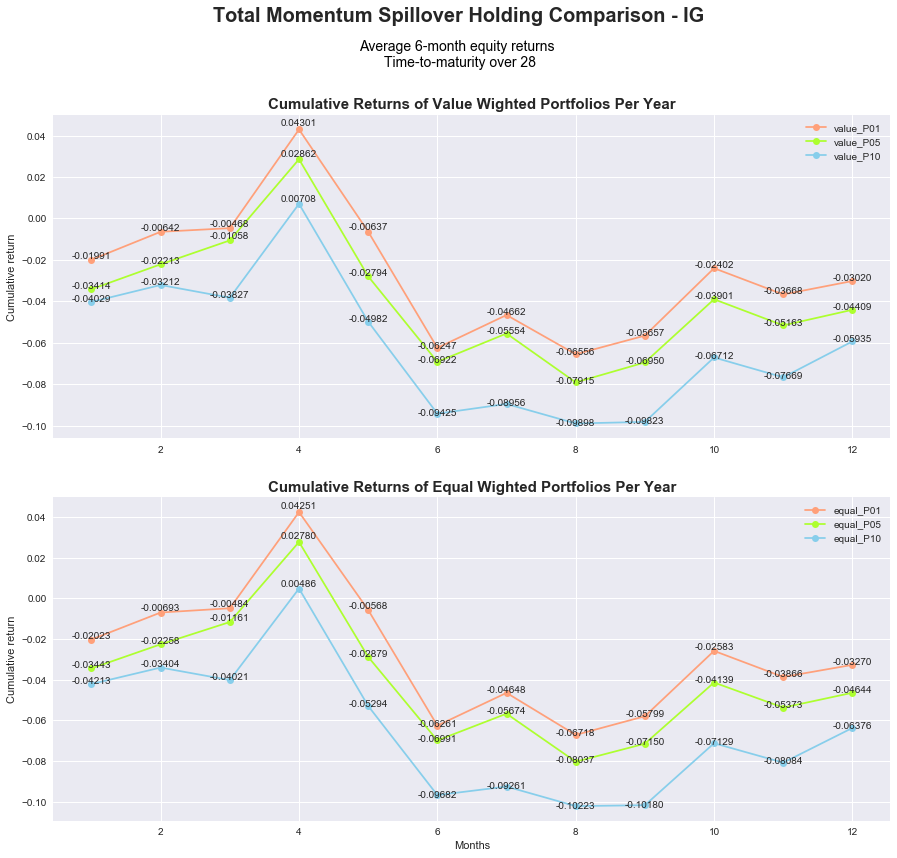

In [15]:
avg_period_IG = 6
com_hold_IG = comparison_holding(equity_data_IG, bond_data_IG, formation_date, avg_period_IG, TMT = TMT_IG)
comparison_holding_plot(com_hold_IG, universe_IG, avg_period_IG, TMT = TMT_IG)

Observe that the systematic pattern could be in the first quarter after formation date. Hence, select the systematic ranges of bond holding to test as below.

In [16]:
holding_range_IG = [(1, 1), (1, 2), (2, 4), (6, 12)]
equity_range = (3, 6, 12)

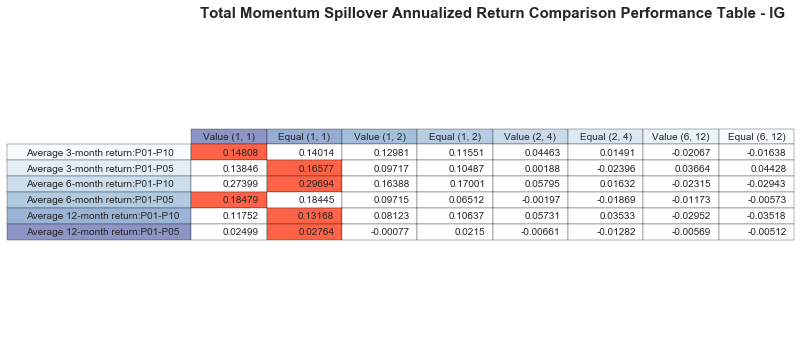

In [17]:
s_type_IG = 0
com_perf_IG = comparison_performance(equity_data_IG, bond_data_IG, holding_range_IG, formation_date, equity_range, TMT=TMT_IG, strat_type = s_type_IG)
comparison_table(com_perf_IG, universe_IG, s_type_IG)

Using 3-month equity return and holding bond porfolios from 1 to 1 with time-to-maturity of bonds over 28 years shows the highest annualized return and momentum effect. We will see more detail of this systematic strategy.

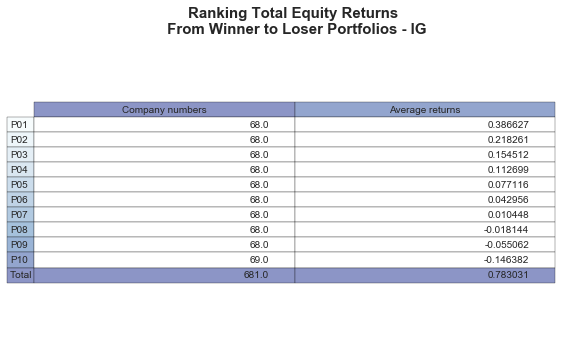

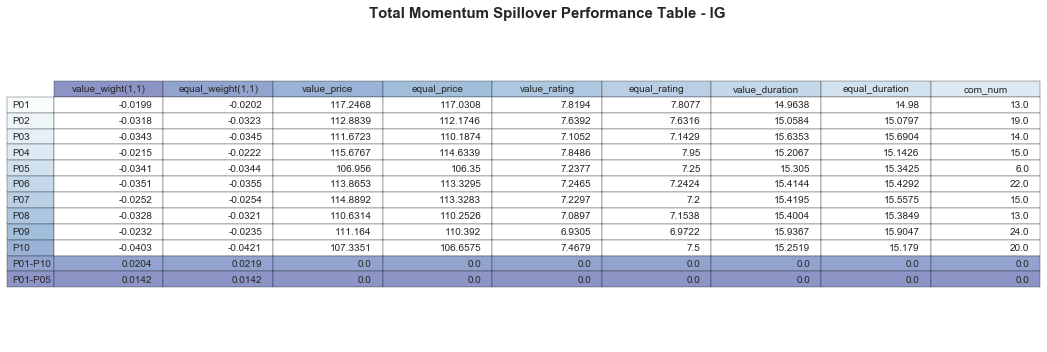

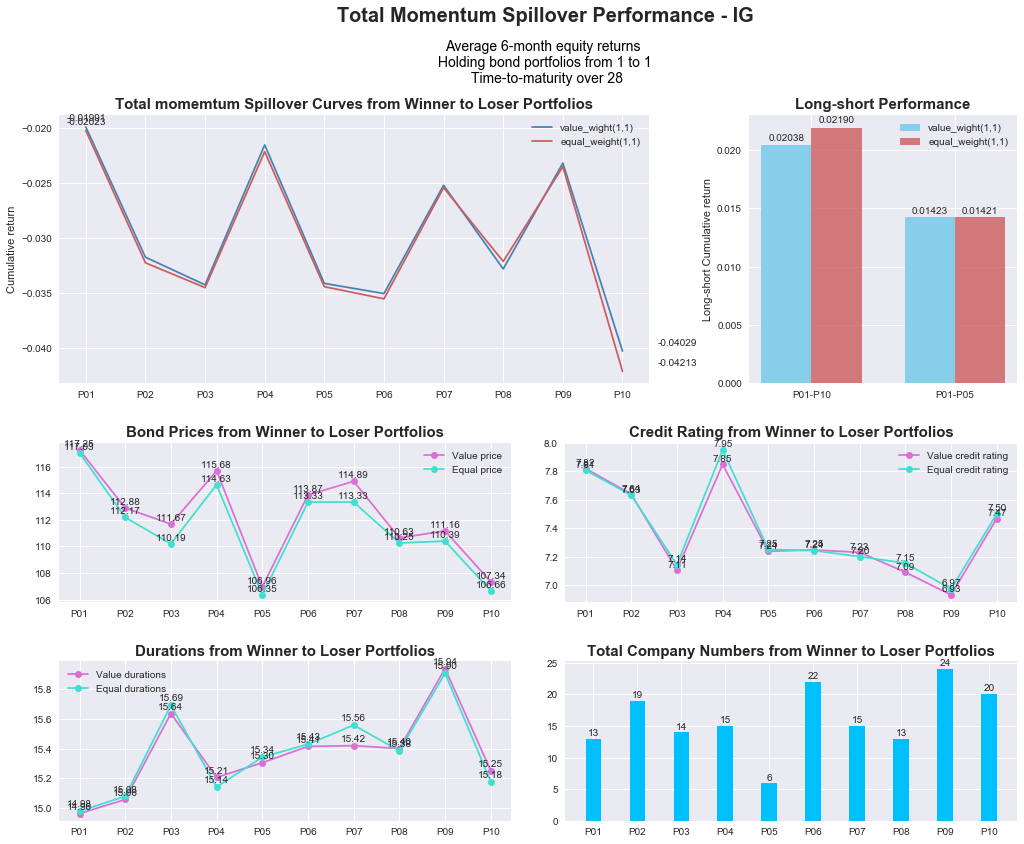

In [18]:
avg_period_IG = 6

rank_port_IG = rank_port_decile(equity_data_IG, formation_date, avg_period_IG, s_type_IG)
rank_table(rank_port_IG, universe_IG, s_type_IG)

hfrom_IG = 1
hend_IG = 1
tmt_IG = 28

perf_IG = momentum_strategy(bond_data_IG, rank_port_IG, hfrom_IG, hend_IG, TMT=TMT_IG)
m_performance_table(perf_IG, universe_IG, s_type_IG)

performance_plot(perf_IG, avg_period_IG, hfrom_IG, hend_IG, tmt_IG, universe_IG, s_type_IG)

The performance of this systematic strategy on IG universe shows fair momentum with gaining around 2% return.

## Backtesting on BBB

Select time-to-maturity of bonds and data universe

In [19]:
TMT_BBB = 5
universe_BBB = 'BBB'

Execute Cumulative Return Holding Per Year Comparison function on BBB universe

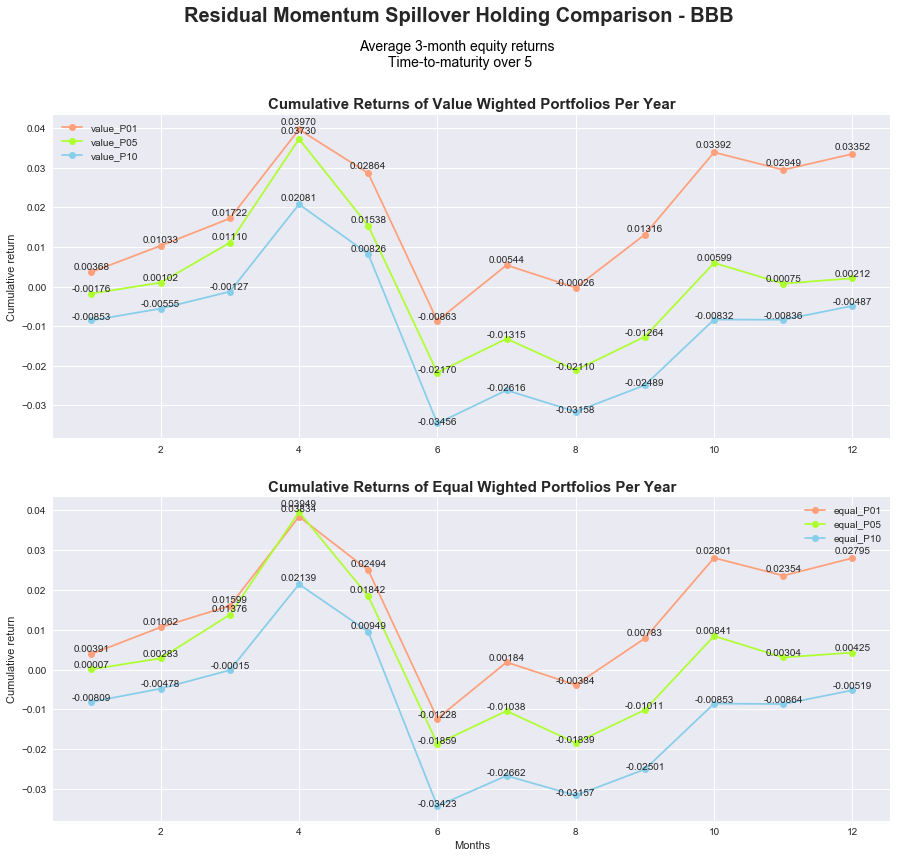

In [20]:
avg_period_BBB = 3
com_hold_BBB = comparison_holding(equity_data_BBB, bond_data_BBB, formation_date, avg_period_BBB, strat_type = 1, TMT = TMT_BBB)
comparison_holding_plot(com_hold_BBB, universe_BBB, avg_period_BBB, TMT = TMT_BBB, strat_type = 1)

Observe that the systematic ranges could be in the first quarter after formation date. Hence, select the systematic ranges of bond holding to test as below.

In [21]:
holding_range_BBB = [(1, 1), (2, 2), (1, 3), (12, 12)]

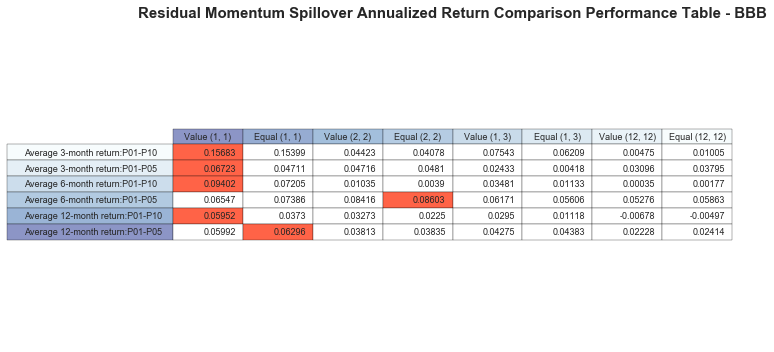

In [22]:
s_type_BBB = 1
com_perf_BBB = comparison_performance(equity_data_BBB, bond_data_BBB, holding_range_BBB, formation_date, equity_range, TMT=TMT_BBB, strat_type = s_type_BBB)
comparison_table(com_perf_BBB, universe_BBB, s_type_BBB)

Using 6-month equity return and holding bond porfolios from 1 to 1 with time-to-maturity of bonds over 5 years shows the highest annualized return and momentum effect. We will see more detail of this systematic strategy.

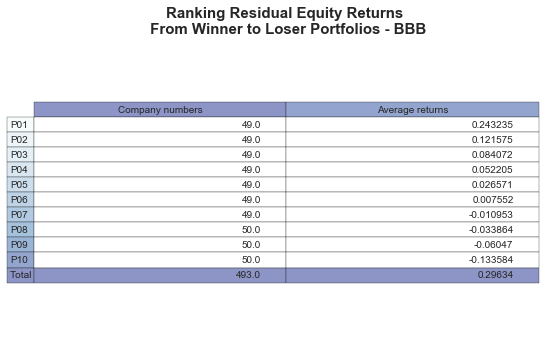

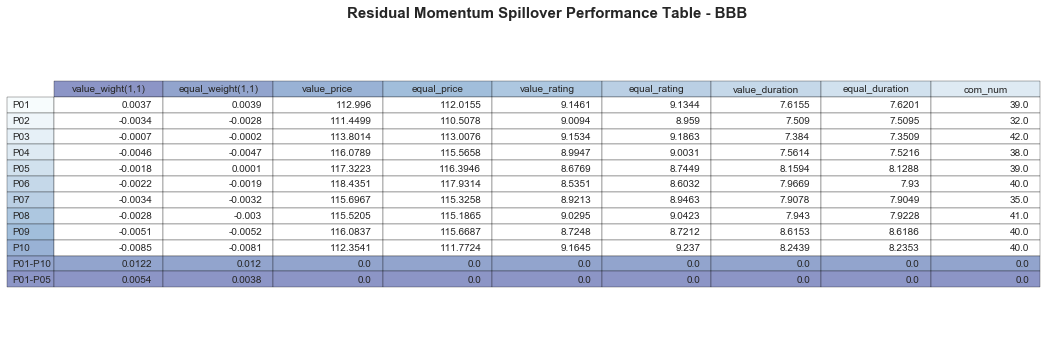

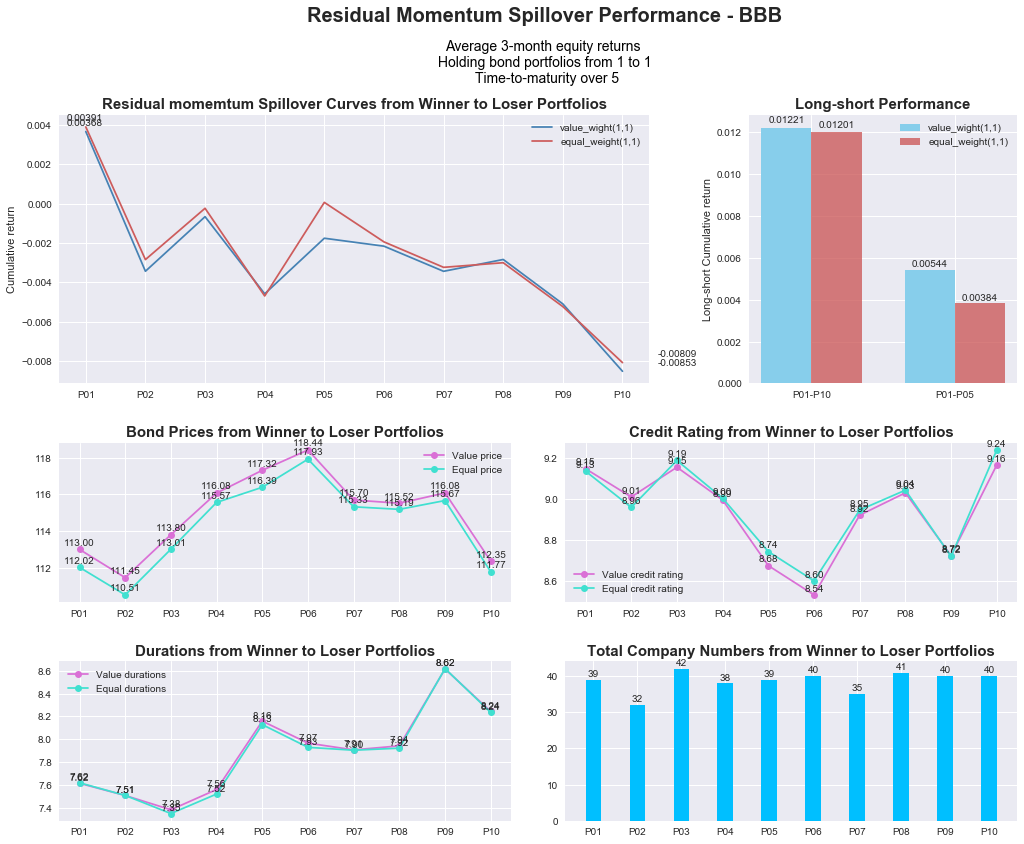

In [23]:
avg_period_BBB = 3

rank_port_BBB = rank_port_decile(equity_data_BBB, formation_date, avg_period_BBB, s_type_BBB)
rank_table(rank_port_BBB, universe_BBB, s_type_BBB)

hfrom_BBB = 1
hend_BBB = 1
tmt_BBB = 5

perf_BBB = momentum_strategy(bond_data_BBB, rank_port_BBB, hfrom_BBB, hend_BBB, TMT=TMT_BBB)
m_performance_table(perf_BBB, universe_BBB, s_type_BBB)

performance_plot(perf_BBB, avg_period_BBB, hfrom_BBB, hend_BBB, tmt_BBB, universe_BBB, s_type_BBB)

The performance of this systematic strategy on BBB universe shows good momentum with gaining around 1.2% return.

## Backtesting on HY

Select time-to-maturity of bonds and data universe

In [24]:
TMT_HY = 1
universe_HY = 'HY'

Execute Cumulative Return Holding Per Year Comparison function on HY universe

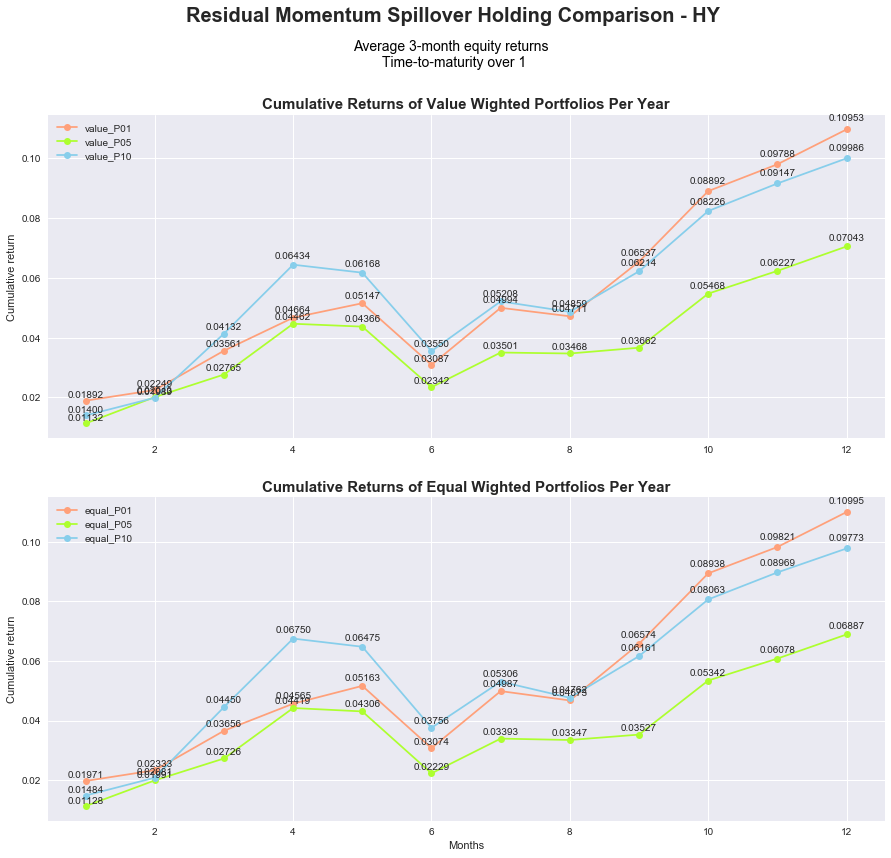

In [25]:
avg_period_HY = 3
com_hold_HY = comparison_holding(equity_data_HY, bond_data_HY, formation_date, avg_period_HY, strat_type = 1, TMT = TMT_HY)
comparison_holding_plot(com_hold_HY, universe_HY, avg_period_HY,TMT = TMT_HY, strat_type = 1)

Observe that the systematic ranges could be in the first,second and after sixth month of formation date. Hence, select the systematic ranges of bond holding to test as below.

In [26]:
holding_range_HY = [(1, 1), (1, 2), (6, 12), (12, 12)]
equity_range_HY = (1, 3, 6)

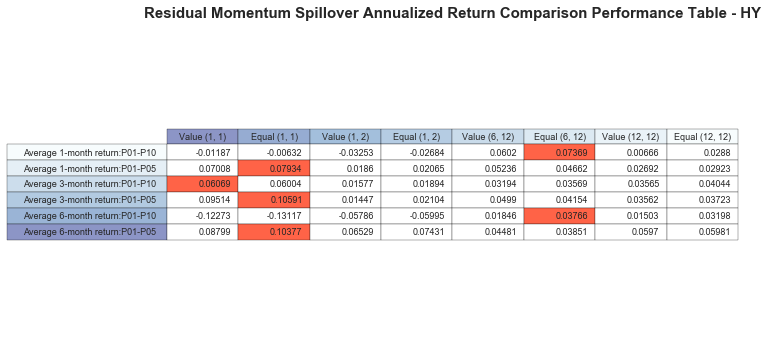

In [27]:
s_type_HY = 1
com_perf_HY = comparison_performance(equity_data_HY, bond_data_HY, holding_range_HY, formation_date, equity_range_HY, TMT=TMT_HY, strat_type = s_type_HY)
comparison_table(com_perf_HY, universe_HY, s_type_HY)

Using 1-month equity return and holding bond porfolios from 6 to 12 with time-to-maturity of bonds over 1 year shows the highest annualized return and momentum effect. We will see more detail of this systematic strategy.

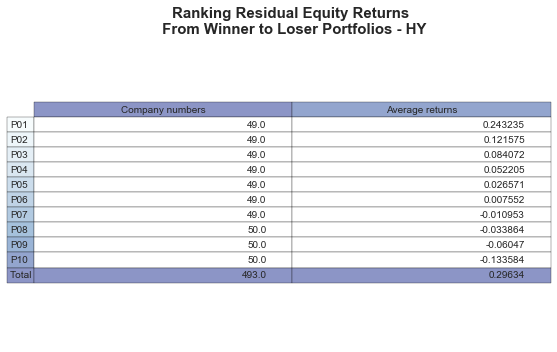

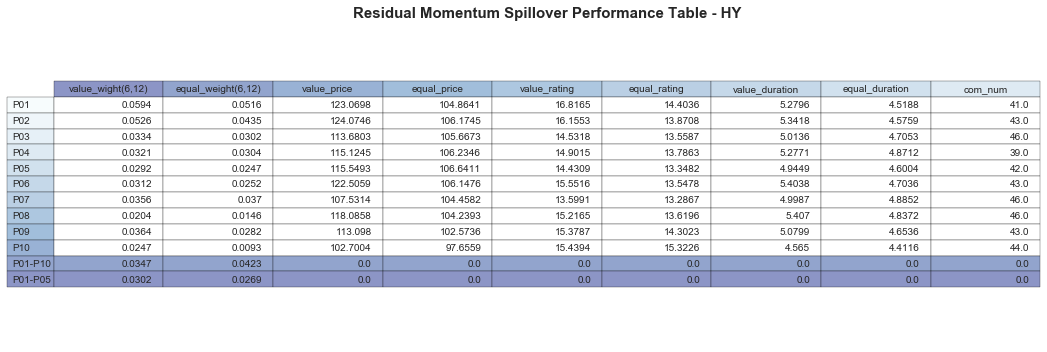

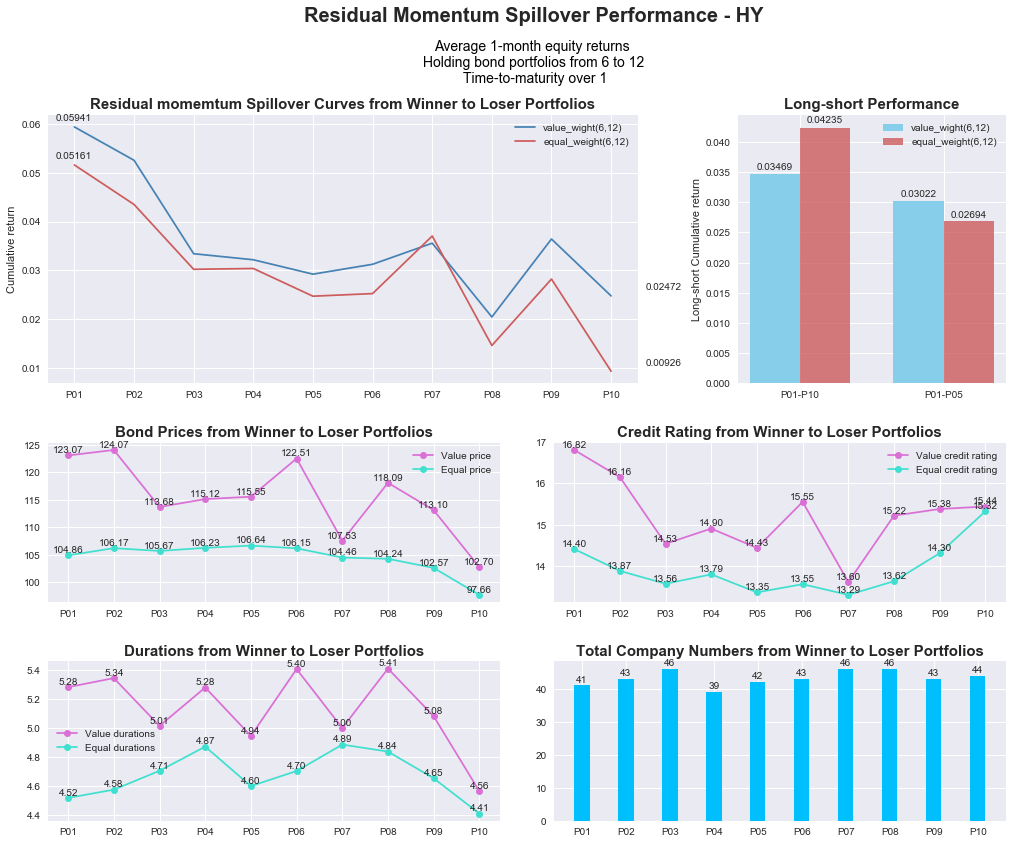

In [28]:
avg_period_HY = 1

rank_port_HY = rank_port_decile(equity_data_HY, formation_date, avg_period_HY, s_type_HY)
rank_table(rank_port_BBB, universe_HY, s_type_HY)

hfrom_HY = 6
hend_HY = 12
tmt_HY = 1

perf_HY = momentum_strategy(bond_data_HY, rank_port_HY, hfrom_HY, hend_HY, TMT=TMT_HY)
m_performance_table(perf_HY, universe_HY, s_type_HY)

performance_plot(perf_HY, avg_period_HY, hfrom_HY, hend_HY, tmt_HY, universe_HY, s_type_HY)

The performance of this systematic strategy on HY universe shows good momentum with earning around 3.5%-4.2% return.